In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [65]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [66]:
class DNN_2(nn.Module):
    def __init__(self, input_dim,dropout1,dropout2,dropout3,dropout4):
        super(DNN_2, self).__init__()
        self.layer1 = nn.Linear(input_dim,64)
        self.layer2 = nn.Linear(64,32)
        self.layer3 = nn.Linear(32,16)
        self.layer4 = nn.Linear(16,8)
        self.output_layer = nn.Linear(8, 1)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        self.dropout3 = nn.Dropout(dropout3)
        self.dropout4 = nn.Dropout(dropout4)

        
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout1(x)
        
        x = torch.relu(self.layer2(x))
        x = self.dropout2(x)

        x = torch.relu(self.layer3(x))
        x = self.dropout3(x)

        x = torch.relu(self.layer4(x))
        x = self.dropout4(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [67]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=4, shuffle=False)

Optunaの設定

In [68]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    dropout3 = trial.suggest_float("dropout3", 0, 0.5, step=0.05)
    dropout4 = trial.suggest_float("dropout4", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整

    # モデル定義
    model = DNN_2(
        input_dim=X_train_tensor.shape[1],
        dropout1=dropout1,
        dropout2=dropout2,
        dropout3=dropout3,
        dropout4=dropout4
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs > 0.49).float()  
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stopping判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 評価指標の計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [69]:
device_id = 0
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-04 16:00:54,394] A new study created in memory with name: no-name-78ac5338-4858-42f0-9609-c8a2fa8fa982
/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:01:46,445] Trial 0 finished with value: 0.3444571811508554 and parameters: {'dropout1': 0.4, 'dropout2': 0.5, 'dropout3': 0.45, 'dropout4': 0.45, 'learning_rate': 0.0009525570879818969}. Best is trial 0 with value: 0.3444571811508554.


Early stopping at epoch 15
Final MCC: 0.3445


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:03:47,587] Trial 1 finished with value: 0.17263532565794473 and parameters: {'dropout1': 0.5, 'dropout2': 0.4, 'dropout3': 0.0, 'dropout4': 0.30000000000000004, 'learning_rate': 0.0004158922631517666}. Best is trial 0 with value: 0.3444571811508554.


Early stopping at epoch 37
Final MCC: 0.1726


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:05:33,066] Trial 2 finished with value: 0.17142857142857143 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dropout3': 0.25, 'dropout4': 0.05, 'learning_rate': 0.0013000562661700577}. Best is trial 0 with value: 0.3444571811508554.


Early stopping at epoch 33
Final MCC: 0.1714


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:07:44,205] Trial 3 finished with value: 0.22046032766546803 and parameters: {'dropout1': 0.0, 'dropout2': 0.5, 'dropout3': 0.2, 'dropout4': 0.0, 'learning_rate': 0.00013930500878631542}. Best is trial 0 with value: 0.3444571811508554.


Early stopping at epoch 44
Final MCC: 0.2205


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:09:46,555] Trial 4 finished with value: 0.3238620405592368 and parameters: {'dropout1': 0.5, 'dropout2': 0.1, 'dropout3': 0.2, 'dropout4': 0.1, 'learning_rate': 0.002609133462789895}. Best is trial 0 with value: 0.3444571811508554.


Early stopping at epoch 40
Final MCC: 0.3239


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:13:26,157] Trial 5 finished with value: 0.1576203816946855 and parameters: {'dropout1': 0.1, 'dropout2': 0.4, 'dropout3': 0.2, 'dropout4': 0.30000000000000004, 'learning_rate': 0.00010437830500818084}. Best is trial 0 with value: 0.3444571811508554.


Early stopping at epoch 73
Final MCC: 0.1576


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:16:06,056] Trial 6 finished with value: 0.30624613682160584 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.35000000000000003, 'dropout3': 0.35000000000000003, 'dropout4': 0.05, 'learning_rate': 0.0001631334300219737}. Best is trial 0 with value: 0.3444571811508554.


Early stopping at epoch 53
Final MCC: 0.3062


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:16:08,997] Trial 7 pruned. 
[I 2024-12-04 16:16:12,019] Trial 8 pruned. 
[I 2024-12-04 16:16:14,886] Trial 9 pruned. 
[I 2024-12-04 16:16:17,845] Trial 10 pruned. 
[I 2024-12-04 16:16:20,767] Trial 11 pruned. 
[I 2024-12-04 16:16:23,476] Trial 12 pruned. 
[I 2024-12-04 16:16:26,279] Trial 13 pruned. 
[I 2024-12-04 16:16:29,344] Trial 14 pruned. 
[I 2024-12-04 16:16:32,389] Trial 15 pruned. 
[I 2024-12-04 16:16:35,420] Trial 16 pruned. 
[I 2024-12-04 16:16:38,353] Trial 17 pruned. 
[I 2024-12-04 16:16:41,347] Trial 18 pruned. 
[I 2024-12-04 16:16:44,389] Trial 19 pruned. 
[I 2024-12-04 16:16:47,460] Trial 20 pruned. 
[I 2024-12-04 16:16:50,440] Trial 

Early stopping at epoch 52
Final MCC: 0.2901


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:22:58,390] Trial 32 finished with value: 0.23303407422663083 and parameters: {'dropout1': 0.0, 'dropout2': 0.5, 'dropout3': 0.15000000000000002, 'dropout4': 0.05, 'learning_rate': 0.00012522651874333736}. Best is trial 0 with value: 0.3444571811508554.


Early stopping at epoch 49
Final MCC: 0.2330


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:23:01,803] Trial 33 pruned. 
[I 2024-12-04 16:25:51,632] Trial 34 finished with value: 0.3350670380926767 and parameters: {'dropout1': 0.05, 'dropout2': 0.4, 'dropout3': 0.25, 'dropout4': 0.1, 'learning_rate': 0.00010529587846183779}. Best is trial 0 with value: 0.3444571811508554.


Early stopping at epoch 48
Final MCC: 0.3351


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:25:55,159] Trial 35 pruned. 
[I 2024-12-04 16:25:58,768] Trial 36 pruned. 
[I 2024-12-04 16:27:53,896] Trial 37 finished with value: 0.31066390097531804 and parameters: {'dropout1': 0.5, 'dropout2': 0.4, 'dropout3': 0.35000000000000003, 'dropout4': 0.05, 'learning_rate': 0.0001308204736675227}. Best is trial 0 with value: 0.3444571811508554.


Early stopping at epoch 33
Final MCC: 0.3107


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:27:57,292] Trial 38 pruned. 
[I 2024-12-04 16:30:43,979] Trial 39 finished with value: 0.21098934859276514 and parameters: {'dropout1': 0.05, 'dropout2': 0.45, 'dropout3': 0.30000000000000004, 'dropout4': 0.25, 'learning_rate': 0.00012471537901226313}. Best is trial 0 with value: 0.3444571811508554.


Early stopping at epoch 46
Final MCC: 0.2110


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:30:47,341] Trial 40 pruned. 
[I 2024-12-04 16:30:50,741] Trial 41 pruned. 
[I 2024-12-04 16:34:47,935] Trial 42 finished with value: 0.34659191007765316 and parameters: {'dropout1': 0.25, 'dropout2': 0.35000000000000003, 'dropout3': 0.35000000000000003, 'dropout4': 0.05, 'learning_rate': 0.00010051000344745869}. Best is trial 42 with value: 0.34659191007765316.


Early stopping at epoch 65
Final MCC: 0.3466


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:34:51,604] Trial 43 pruned. 
[I 2024-12-04 16:38:47,130] Trial 44 finished with value: 0.2619978189658401 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.45, 'dropout3': 0.45, 'dropout4': 0.05, 'learning_rate': 0.00013929284905076777}. Best is trial 42 with value: 0.34659191007765316.


Early stopping at epoch 62
Final MCC: 0.2620


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:44:09,141] Trial 45 finished with value: 0.2901023219738108 and parameters: {'dropout1': 0.5, 'dropout2': 0.2, 'dropout3': 0.35000000000000003, 'dropout4': 0.15000000000000002, 'learning_rate': 0.00010995790289182664}. Best is trial 42 with value: 0.34659191007765316.


Early stopping at epoch 86
Final MCC: 0.2901


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:47:25,294] Trial 46 finished with value: 0.2534777411351246 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.35000000000000003, 'dropout3': 0.4, 'dropout4': 0.45, 'learning_rate': 0.00010098938272805745}. Best is trial 42 with value: 0.34659191007765316.


Early stopping at epoch 52
Final MCC: 0.2535


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:47:28,924] Trial 47 pruned. 
[I 2024-12-04 16:47:32,629] Trial 48 pruned. 
[I 2024-12-04 16:47:36,341] Trial 49 pruned. 
[I 2024-12-04 16:47:39,994] Trial 50 pruned. 
[I 2024-12-04 16:51:30,935] Trial 51 finished with value: 0.30220915702878676 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.15000000000000002, 'dropout3': 0.4, 'dropout4': 0.05, 'learning_rate': 0.00014686705598763213}. Best is trial 42 with value: 0.34659191007765316.


Early stopping at epoch 61
Final MCC: 0.3022


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:51:34,703] Trial 52 pruned. 
[I 2024-12-04 16:51:38,524] Trial 53 pruned. 
[I 2024-12-04 16:51:42,356] Trial 54 pruned. 
[I 2024-12-04 16:51:46,265] Trial 55 pruned. 
[I 2024-12-04 16:51:50,145] Trial 56 pruned. 
[I 2024-12-04 16:51:53,944] Trial 57 pruned. 
[I 2024-12-04 16:51:57,699] Trial 58 pruned. 
[I 2024-12-04 16:52:01,504] Trial 59 pruned. 
[I 2024-12-04 16:52:05,274] Trial 60 pruned. 
[I 2024-12-04 16:52:09,032] Trial 61 pruned. 
[I 2024-12-04 16:52:12,883] Trial 62 pruned. 
[I 2024-12-04 16:55:35,808] Trial 63 finished with value: 0.286529479613142 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.15000000000000002, 'dropout3'

Early stopping at epoch 52
Final MCC: 0.2865


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 16:55:39,694] Trial 64 pruned. 
[I 2024-12-04 16:55:43,435] Trial 65 pruned. 
[I 2024-12-04 16:55:47,209] Trial 66 pruned. 
[I 2024-12-04 16:55:50,953] Trial 67 pruned. 
[I 2024-12-04 16:55:54,829] Trial 68 pruned. 
[I 2024-12-04 17:00:48,523] Trial 69 finished with value: 0.2633297623254712 and parameters: {'dropout1': 0.5, 'dropout2': 0.25, 'dropout3': 0.30000000000000004, 'dropout4': 0.05, 'learning_rate': 0.00010227209972288011}. Best is trial 42 with value: 0.34659191007765316.


Early stopping at epoch 77
Final MCC: 0.2633


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:02:55,166] Trial 70 finished with value: 0.2950773086964557 and parameters: {'dropout1': 0.45, 'dropout2': 0.4, 'dropout3': 0.25, 'dropout4': 0.4, 'learning_rate': 0.000217868083904031}. Best is trial 42 with value: 0.34659191007765316.


Early stopping at epoch 32
Final MCC: 0.2951


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:05:29,696] Trial 71 finished with value: 0.0699230178027249 and parameters: {'dropout1': 0.45, 'dropout2': 0.4, 'dropout3': 0.25, 'dropout4': 0.4, 'learning_rate': 0.00011929895539222144}. Best is trial 42 with value: 0.34659191007765316.


Early stopping at epoch 39
Final MCC: 0.0699


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:05:33,563] Trial 72 pruned. 
[I 2024-12-04 17:05:37,411] Trial 73 pruned. 
[I 2024-12-04 17:05:41,235] Trial 74 pruned. 
[I 2024-12-04 17:05:45,073] Trial 75 pruned. 
[I 2024-12-04 17:11:15,068] Trial 76 finished with value: 0.3062127263296445 and parameters: {'dropout1': 0.4, 'dropout2': 0.4, 'dropout3': 0.25, 'dropout4': 0.05, 'learning_rate': 0.00015587334572767655}. Best is trial 42 with value: 0.34659191007765316.


Early stopping at epoch 89
Final MCC: 0.3062


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:11:18,568] Trial 77 pruned. 
[I 2024-12-04 17:11:22,046] Trial 78 pruned. 
[I 2024-12-04 17:13:05,236] Trial 79 finished with value: 0.32017622069699025 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.45, 'dropout3': 0.25, 'dropout4': 0.1, 'learning_rate': 0.00015055943131910102}. Best is trial 42 with value: 0.34659191007765316.


Early stopping at epoch 28
Final MCC: 0.3202


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:13:08,855] Trial 80 pruned. 
[I 2024-12-04 17:13:12,613] Trial 81 pruned. 
[I 2024-12-04 17:16:02,747] Trial 82 finished with value: 0.30730442030883687 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.5, 'dropout3': 0.25, 'dropout4': 0.05, 'learning_rate': 0.00012431665073611792}. Best is trial 42 with value: 0.34659191007765316.


Early stopping at epoch 51
Final MCC: 0.3073


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:18:24,969] Trial 83 finished with value: 0.3657176470950697 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.5, 'dropout3': 0.25, 'dropout4': 0.1, 'learning_rate': 0.00013059339987377878}. Best is trial 83 with value: 0.3657176470950697.


Early stopping at epoch 44
Final MCC: 0.3657


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:21:13,063] Trial 84 finished with value: 0.33133820647811774 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.5, 'dropout3': 0.25, 'dropout4': 0.1, 'learning_rate': 0.00012821946388615085}. Best is trial 83 with value: 0.3657176470950697.


Early stopping at epoch 52
Final MCC: 0.3313


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:21:16,276] Trial 85 pruned. 
[I 2024-12-04 17:21:19,476] Trial 86 pruned. 
[I 2024-12-04 17:23:26,341] Trial 87 finished with value: 0.32756920994133026 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'dropout3': 0.25, 'dropout4': 0.15000000000000002, 'learning_rate': 0.0001294747991051311}. Best is trial 83 with value: 0.3657176470950697.


Early stopping at epoch 39
Final MCC: 0.3276


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:23:29,538] Trial 88 pruned. 
[I 2024-12-04 17:26:35,809] Trial 89 finished with value: 0.30348848933344197 and parameters: {'dropout1': 0.2, 'dropout2': 0.5, 'dropout3': 0.2, 'dropout4': 0.15000000000000002, 'learning_rate': 0.00011409491252137955}. Best is trial 83 with value: 0.3657176470950697.


Early stopping at epoch 58
Final MCC: 0.3035


/tmp/ipykernel_183729/3461470650.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-12-04 17:26:39,015] Trial 90 pruned. 
[I 2024-12-04 17:26:42,223] Trial 91 pruned. 
[I 2024-12-04 17:26:45,435] Trial 92 pruned. 
[I 2024-12-04 17:26:48,613] Trial 93 pruned. 
[I 2024-12-04 17:26:51,750] Trial 94 pruned. 
[I 2024-12-04 17:26:54,898] Trial 95 pruned. 
[I 2024-12-04 17:26:58,107] Trial 96 pruned. 
[I 2024-12-04 17:27:01,299] Trial 97 pruned. 
[I 2024-12-04 17:27:04,508] Trial 98 pruned. 
[I 2024-12-04 17:27:07,676] Trial 99 pruned. 


Best Parameters:  {'dropout1': 0.35000000000000003, 'dropout2': 0.5, 'dropout3': 0.25, 'dropout4': 0.1, 'learning_rate': 0.00013059339987377878}
Best Validation F1:  0.3657176470950697


Epoch [1/100], Loss: 0.6733
Epoch [1/100], Train Loss: 0.6733, Val Loss: 0.6217
Epoch [2/100], Loss: 0.6186
Epoch [2/100], Train Loss: 0.6186, Val Loss: 0.5899
Epoch [3/100], Loss: 0.5999
Epoch [3/100], Train Loss: 0.5999, Val Loss: 0.5830
Epoch [4/100], Loss: 0.5970
Epoch [4/100], Train Loss: 0.5970, Val Loss: 0.5804
Epoch [5/100], Loss: 0.5892
Epoch [5/100], Train Loss: 0.5892, Val Loss: 0.5792
Epoch [6/100], Loss: 0.5827
Epoch [6/100], Train Loss: 0.5827, Val Loss: 0.5779
Epoch [7/100], Loss: 0.5830
Epoch [7/100], Train Loss: 0.5830, Val Loss: 0.5768
Epoch [8/100], Loss: 0.5777
Epoch [8/100], Train Loss: 0.5777, Val Loss: 0.5767
Epoch [9/100], Loss: 0.5777
Epoch [9/100], Train Loss: 0.5777, Val Loss: 0.5758
Epoch [10/100], Loss: 0.5728
Epoch [10/100], Train Loss: 0.5728, Val Loss: 0.5747
Epoch [11/100], Loss: 0.5720
Epoch [11/100], Train Loss: 0.5720, Val Loss: 0.5730
Epoch [12/100], Loss: 0.5740
Epoch [12/100], Train Loss: 0.5740, Val Loss: 0.5717
Epoch [13/100], Loss: 0.5708
Epoch

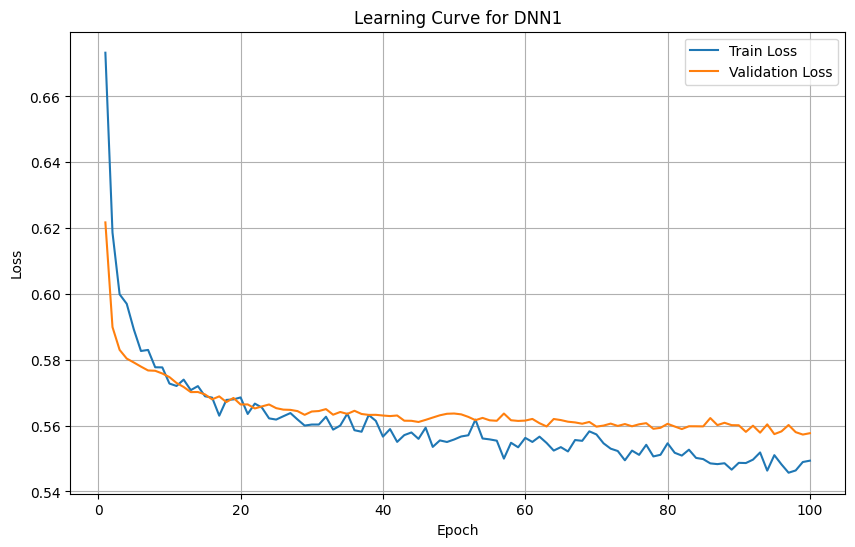

In [70]:
best_params=study.best_params
model = DNN_2(input_dim=X_train_tensor.shape[1],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],
              dropout3=best_params["dropout3"],
              dropout4=best_params["dropout4"]).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 58.20%
Precision: 0.4760
Recall: 0.8201
F1 Score: 0.6024
Matthews Correlation Coefficient: 0.2603
Specificity: 0.4323


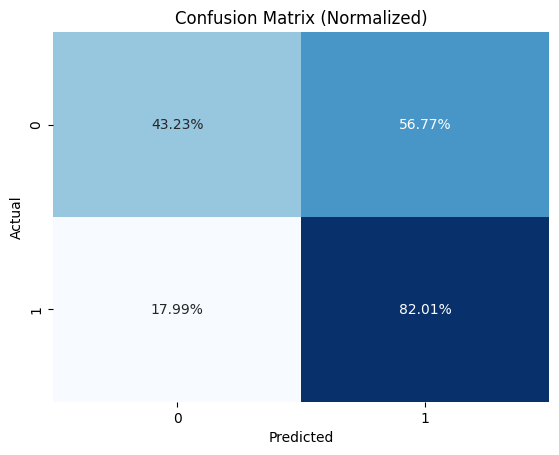

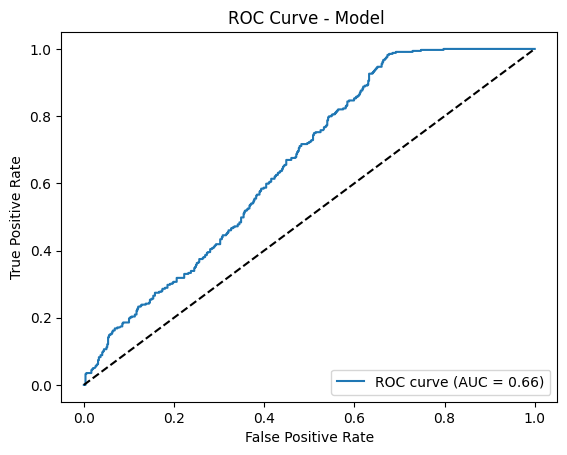

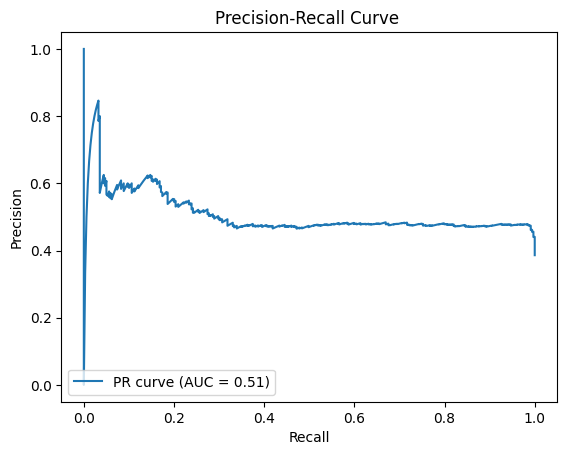

In [71]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs > 0.49).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [72]:
# モデルと構造を保存
torch.save(model.state_dict(), '../../saved_model/DNN_2.pth')

